In [1]:
import caret
from xgboost import *

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.tabular import *
import os
import time
from xgboost import *

In [4]:
PATH = Path('/storage/santander_comp/')

In [5]:
train = pd.read_csv(PATH/'train.csv', engine = 'python')

In [6]:
test = pd.read_csv(PATH/'test.csv', engine = 'python')

In [7]:
train.drop('ID_code', inplace = True, axis = 1)
test.drop('ID_code', inplace = True, axis = 1)

In [8]:
augmented_features = ['min', 'mean', 'max', 'median', 'std', 'abs_mean', 'abs_median', 'abs_std', 'skew', 'kurt', 'sq_kurt']


In [9]:
# get the features list
features = [feature for feature in train.columns if 'var' in feature]
len(features)

200

In [10]:
def augment_df(df):
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
        df[f'repo_sq_{feature}'] = df[f'sq_{feature}'].apply(lambda x: 0 if x==0 else 1/x)
    
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)
    

In [11]:
augment_df(train)

In [12]:
augment_df(test)

In [15]:
train.shape

(200000, 813)

In [16]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,max,median,std,var,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,39.283173,6.668643,9.657404,93.584865,9.315585,7.894286,7.228956,-0.177261,2.242584,19.779803
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,5.643665,0.402602,0.565163,10.969331,0.335117,0.467109,0.465629,0.392514,1.450894,12.887132
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,22.719500,4.831100,7.328641,53.708972,7.820990,6.129450,5.347387,-2.568800,-0.374018,1.206168
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,35.217300,6.398300,9.268811,85.910858,9.087254,7.565750,6.905384,-0.410170,1.313078,11.344336
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,38.899400,6.682200,9.643002,92.987488,9.313394,7.885850,7.214661,-0.149470,1.916551,16.440346
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,42.957250,6.936800,10.031496,100.630906,9.540688,8.211450,7.534798,0.088063,2.749177,24.214145
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,84.684100,8.741900,12.179116,148.330865,10.788287,9.893100,9.659714,2.001981,22.044093,146.813460


In [25]:
train_df = train.copy()
test_df = test.copy()

In [27]:
target = train_df['target']

In [17]:
random.seed(2019)
valid_idx = random.sample(list(train.index.values), int(len(train)*0.1) )

In [18]:
# make sure distributions are roughly the same between training and test
train.iloc[valid_idx].target.sum() / len(valid_idx) , train.target.sum() / len(train)

(0.0956, 0.10049)

In [19]:
features = features + [f'sq_{feature}' for feature in features] + [f'repo_{feature}' for feature in features] + [f'repo_sq_{feature}' for feature in features]
len(features) 

800

In [35]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.02,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [23]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [36]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.88752	valid_1's auc: 0.868245
[2000]	training's auc: 0.90609	valid_1's auc: 0.882023
[3000]	training's auc: 0.916947	valid_1's auc: 0.88923
[4000]	training's auc: 0.924543	valid_1's auc: 0.893432
[5000]	training's auc: 0.930562	valid_1's auc: 0.895608
[6000]	training's auc: 0.935714	valid_1's auc: 0.897173
[7000]	training's auc: 0.940272	valid_1's auc: 0.897904
[8000]	training's auc: 0.944465	valid_1's auc: 0.898539
[9000]	training's auc: 0.948363	valid_1's auc: 0.898654
[10000]	training's auc: 0.952106	valid_1's auc: 0.898835
[11000]	training's auc: 0.955619	valid_1's auc: 0.898733
[12000]	training's auc: 0.958977	valid_1's auc: 0.898861
[13000]	training's auc: 0.962126	valid_1's auc: 0.898839
[14000]	training's auc: 0.965116	valid_1's auc: 0.89881
Early stopping, best iteration is:
[11421]	training's auc: 0.957052	valid_1's auc: 0.898963
Fold 1
Training until validation scores don't improv

[9000]	training's auc: 0.947965	valid_1's auc: 0.903668
[10000]	training's auc: 0.951756	valid_1's auc: 0.903539
[11000]	training's auc: 0.955211	valid_1's auc: 0.903496
Early stopping, best iteration is:
[8189]	training's auc: 0.944687	valid_1's auc: 0.903741
Fold 9
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.887436	valid_1's auc: 0.872166
[2000]	training's auc: 0.905834	valid_1's auc: 0.88546
[3000]	training's auc: 0.916881	valid_1's auc: 0.891749
[4000]	training's auc: 0.924554	valid_1's auc: 0.895285
[5000]	training's auc: 0.930508	valid_1's auc: 0.896956
[6000]	training's auc: 0.935618	valid_1's auc: 0.898188
[7000]	training's auc: 0.940237	valid_1's auc: 0.898682
[8000]	training's auc: 0.944487	valid_1's auc: 0.899051
[9000]	training's auc: 0.948511	valid_1's auc: 0.899224
[10000]	training's auc: 0.95219	valid_1's auc: 0.899285
[11000]	training's auc: 0.955684	valid_1's auc: 0.899358
[12000]	training's auc: 0.959008	valid_1's auc: 0.89

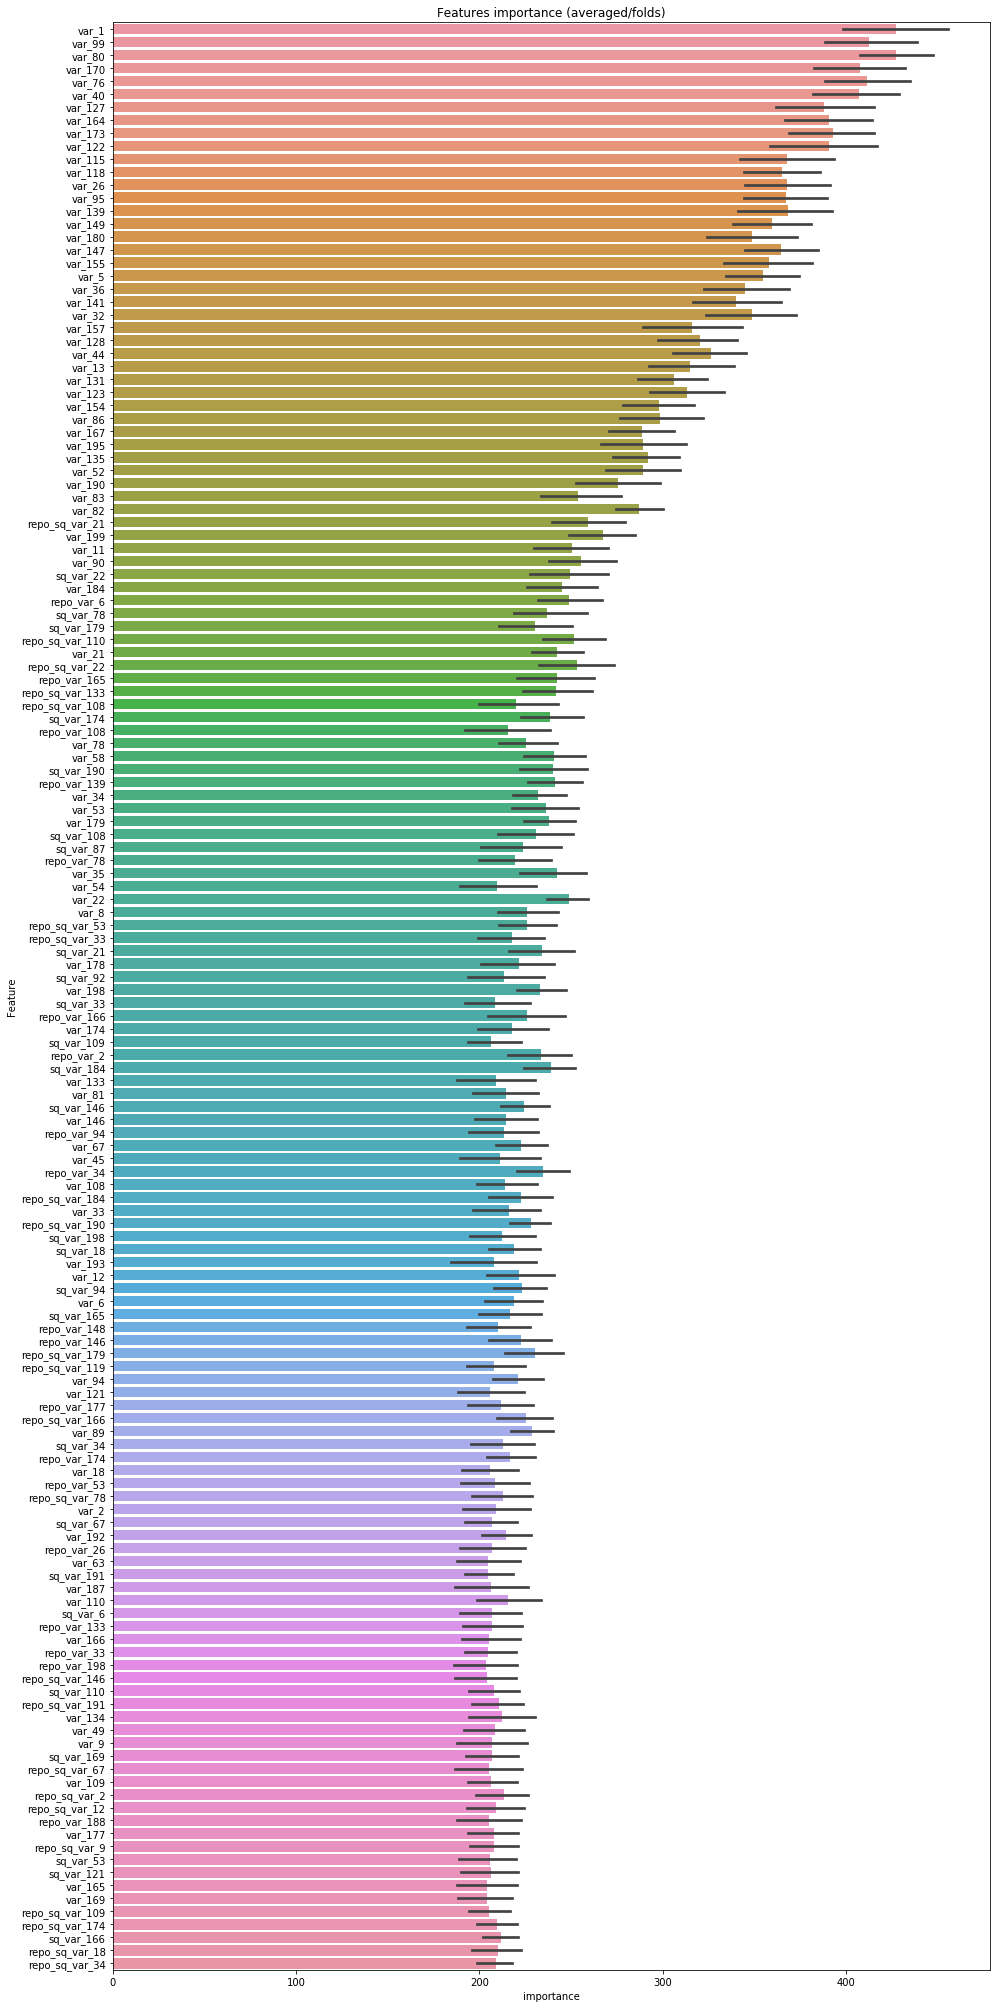

In [29]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [31]:
test2 = pd.read_csv(PATH/'test.csv', engine = 'python')

In [37]:
sub_df = pd.DataFrame({"ID_code":test2["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("sub_xgboost.csv", index=False)

In [38]:
sub_df.head()

,ID_code,target
0,test_0,0.087342
1,test_1,0.196435
2,test_2,0.144430
3,test_3,0.186869
4,test_4,0.042925


In [39]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f sub_xgboost.csv -m "Message"

100%|######################################| 6.06M/6.06M [00:01<00:00, 5.48MB/s]
Successfully submitted to Santander Customer Transaction Prediction

In [81]:
procs = Normalize